# Wasserstein GAN in Pytorch

In [1]:
%matplotlib inline
import sys
print(sys.executable)
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

/home/flend/anaconda3/envs/pytorch/bin/python


Using TensorFlow backend.
/home/flend/anaconda3/envs/pytorch/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import torch_utils; importlib.reload(torch_utils)
from torch_utils import *

The good news is that in the last month the GAN training problem has been solved! [This paper](https://arxiv.org/abs/1701.07875) shows a minor change to the loss function and constraining the weights allows a GAN to reliably learn following a consistent loss schedule.

First, we, set up batch size, image size, and size of noise vector:

In [4]:
bs,sz,nz = 64,64,100

Load dungeon maps from data/maps

In [81]:
import csvdataset; importlib.reload(csvdataset)
from csvdataset import CSVDataset

mapsLoader = CSVDataset("data/maps", "map", 2000)
dataloader = torch.utils.data.DataLoader(mapsLoader, bs, True, num_workers=4)

n = len(dataloader);
n

32

In [82]:
mapsLoader[0].shape

torch.Size([1, 64, 64])

Our activation function will be `tanh`, so we need to do some processing to view the generated images.

In [83]:
def show(img, fs=(6,6)):
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')

## Create model

The CNN definitions are a little big for a notebook, so we import them.

In [123]:
import dcgan; importlib.reload(dcgan)
from dcgan import DCGAN_D, DCGAN_G

Pytorch uses `module.apply()` for picking an initializer.

In [124]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [125]:
netG = DCGAN_G(sz, nz, 1, 64, 1, 1).cuda()
netG.apply(weights_init);

In [126]:
netD = DCGAN_D(sz, 1, 64, 1, 1).cuda()
netD.apply(weights_init);

Just some shortcuts to create tensors and variables.

In [127]:
from torch import FloatTensor as FT
def Var(*params): return Variable(FT(*params).cuda())

In [128]:
def create_noise(b): 
    return Variable(FT(b, nz, 1, 1).cuda().normal_(0, 1))

In [129]:
# Input placeholder
input = Var(bs, 3, sz, nz)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)
# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

An optimizer needs to be told what variables to optimize. A module automatically keeps track of its variables.

In [130]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

One forward step and one backward step for D

In [131]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [132]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [133]:
lossD = []
lossG = []
lossDreal = []
lossDfake = []

In [134]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in range(niter):
        epoch_filename = str.format('gen_epoch_{}.pt', epoch)
        torch.save(netG, epoch_filename)
        data_iter = iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5)

            j = 0
            while j < d_iters and i < n:
                j += 1; i += 1
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = Variable(next(data_iter).cuda())
                netD.zero_grad()
                errD_real = step_D(real, one)

                fake = netG(create_noise(real.size()[0]))
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errD = errD_real - errD_fake
                optimizerD.step()
                #print('i[%d]' % i)

            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(bs)), one)
            optimizerG.step()
            gen_iterations += 1
            
            print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f' % (
            epoch, niter, gen_iterations, n,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))
            lossD.append(errD.data[0])
            lossG.append(errG.data[0])
            lossDreal.append(errD_real.data[0])
            lossDfake.append(errD_fake.data[0])


In [ ]:
%time train(4000, True)

[0/4000][1/32] Loss_D: -1.275862 Loss_G: 0.665388 Loss_D_real: -0.642484 Loss_D_fake 0.633378
[1/4000][2/32] Loss_D: -1.424190 Loss_G: 0.732299 Loss_D_real: -0.716624 Loss_D_fake 0.707566
[2/4000][3/32] Loss_D: -1.456926 Loss_G: 0.741057 Loss_D_real: -0.738825 Loss_D_fake 0.718101
[3/4000][4/32] Loss_D: -1.461371 Loss_G: 0.739793 Loss_D_real: -0.742043 Loss_D_fake 0.719328
[4/4000][5/32] Loss_D: -1.461658 Loss_G: 0.739085 Loss_D_real: -0.739429 Loss_D_fake 0.722229
[5/4000][6/32] Loss_D: -1.471071 Loss_G: 0.740503 Loss_D_real: -0.747360 Loss_D_fake 0.723711
[6/4000][7/32] Loss_D: -1.467745 Loss_G: 0.738114 Loss_D_real: -0.746052 Loss_D_fake 0.721693
[7/4000][8/32] Loss_D: -1.463342 Loss_G: 0.737078 Loss_D_real: -0.742991 Loss_D_fake 0.720351
[8/4000][9/32] Loss_D: -1.470382 Loss_G: 0.741890 Loss_D_real: -0.744216 Loss_D_fake 0.726166


In [105]:
# dimension checking
#batch = next(iter(dataloader))
#batch


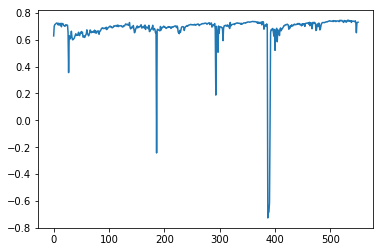

In [107]:
plt.plot(lossDfake)

## View

In [108]:
fake = netG(fixed_noise).data.cpu()

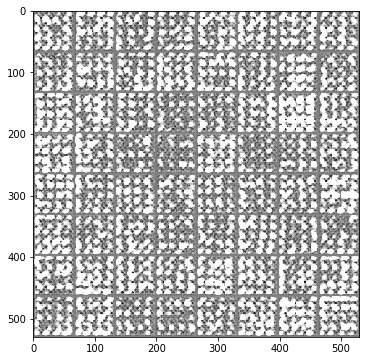

In [109]:
show(vutils.make_grid(fake))

In [101]:
fakeshow(vutils.make_grid(iter(dataloader).next()[0]))

NameError: name 'fakeshow' is not defined

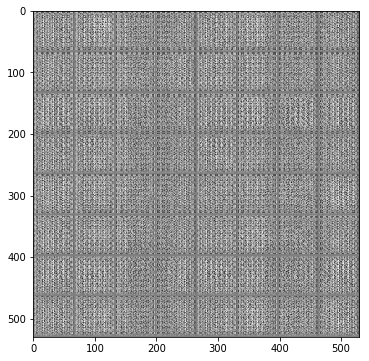

In [102]:
show(vutils.make_grid(fake))

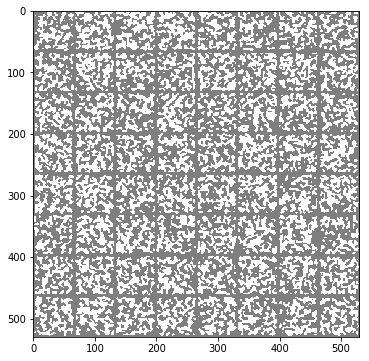

In [104]:
show(vutils.make_grid(iter(dataloader).next()))